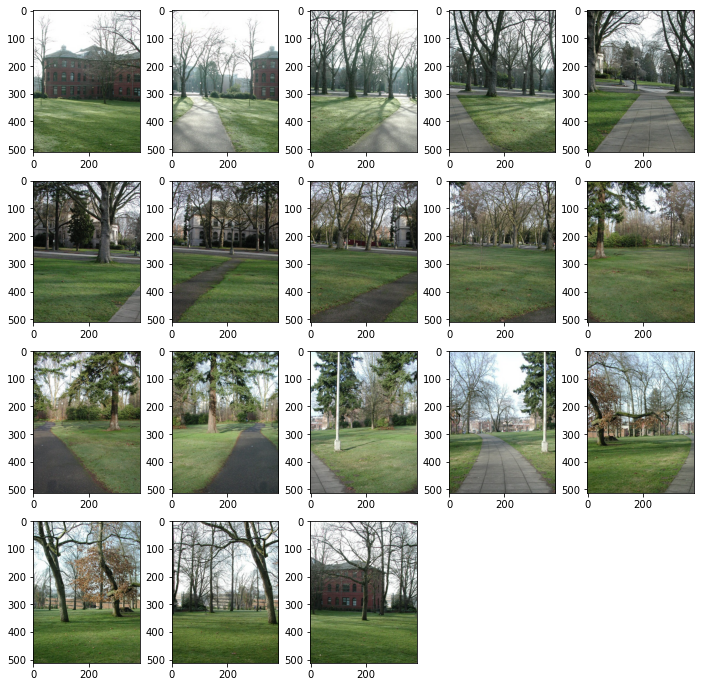

In [1]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

focal_len = 705
path = "./data/parrington/prtn*.jpg"
files = glob.glob(path)
files.sort(reverse=False)
images = [cv2.imread(f) for f in files]

plt.figure(figsize=(12,12))
for i in range(len(images)):
    plt.subplot(4, math.ceil(len(images)/4), i+1)
    plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))

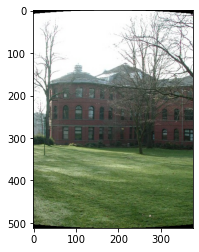

In [2]:
def warp(image):
    result_width = round(math.atan(image.shape[1]/2/focal_len) * focal_len * 2)
    result_height = image.shape[0]
    origin_center_x = (image.shape[1]-1) / 2
    origin_center_y = (image.shape[0]-1) / 2

    result_center_x = (result_width-1) / 2
    result_center_y = (result_height-1) / 2

    # print(image.shape[1], image.shape[0])

    # print(result_width, result_height)

    def project_pixel(i, j):
        theta = (i - result_center_x)/focal_len
        h = j - result_center_y

        #print(i)
        # print(origin_center_x)
        x = round(focal_len * math.tan(theta) + origin_center_x)
        y = round(h / math.cos(theta) + origin_center_y)

        if x < 0 or y < 0 or x >= image.shape[1] or y >= image.shape[0]:
            return np.zeros(3)
        else:
            return image[y][x]

    result_image_idx = np.ndindex((result_height, result_width))
    result_image = np.array([project_pixel(j, i) for i, j in result_image_idx])
    return result_image.astype(np.uint8).reshape(result_height, result_width, 3)
    #return np.fromfunction(lambda i, j: project_pixel(i, j), (result_width, result_height), dtype=int)
img_warp = warp(images[0])
plt.imshow( cv2.cvtColor(img_warp, cv2.COLOR_BGR2RGB))



In [3]:
# s = focal_len
# def warp_image(image):
#     result_image = np.zeros((image.shape[0], image.shape[1], 3))
#     center_y = image.shape[0] // 2
#     center_x = image.shape[1] // 2
#     def project_pixel(y, x):
#         now_y, now_x = y-center_y, x-center_x
#         h = now_y / math.sqrt(now_x**2 + focal_len**2) * s
#         theta = math.atan(now_y/focal_len) * s
#         result_image[round(center_y+h)][round(center_x+now_x)] = image[y][x]
    
#     result_image_idx = np.ndindex((image.shape[0], image.shape[1]))
#     [project_pixel(i,j) for i,j in result_image_idx]
#     return result_image.astype(np.uint8)
# img_warp = warp_image(images[0])
# plt.imshow(img_warp)

<Figure size 432x288 with 0 Axes>

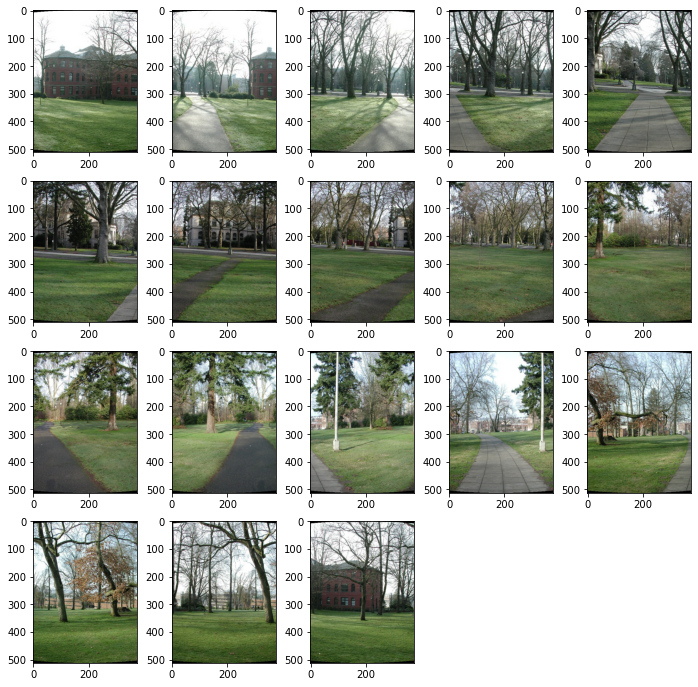

In [4]:
result_images = [warp(img) for img in images]

plt.clf()
plt.figure(figsize=(12,12))
for i in range(len(result_images)):
    plt.subplot(4, math.ceil(len(result_images)/4), i+1)
    plt.imshow(cv2.cvtColor(result_images[i], cv2.COLOR_BGR2RGB))

## Detection

In [40]:
def harris(gray_img, ksize, gksize, k, threshold):
    gray_img = np.float64(gray_img)
    dx = cv2.Sobel(gray_img, -1, 1, 0, ksize)
    dy = cv2.Sobel(gray_img, -1, 0, 1, ksize)
    
    Ixx = cv2.multiply(dx, dx)
    Iyy = cv2.multiply(dy, dy)
    Ixy = cv2.multiply(dx, dy)
    Sxx = cv2.GaussianBlur(Ixx, (gksize, gksize), 0)
    Syy = cv2.GaussianBlur(Iyy, (gksize, gksize), 0)
    Sxy = cv2.GaussianBlur(Ixy, (gksize, gksize), 0)

    det = cv2.multiply(Sxx, Syy) - cv2.multiply(Sxy, Sxy)
    trace = Sxx + Syy
    R = det - k * cv2.multiply(trace, trace)
    
    return R

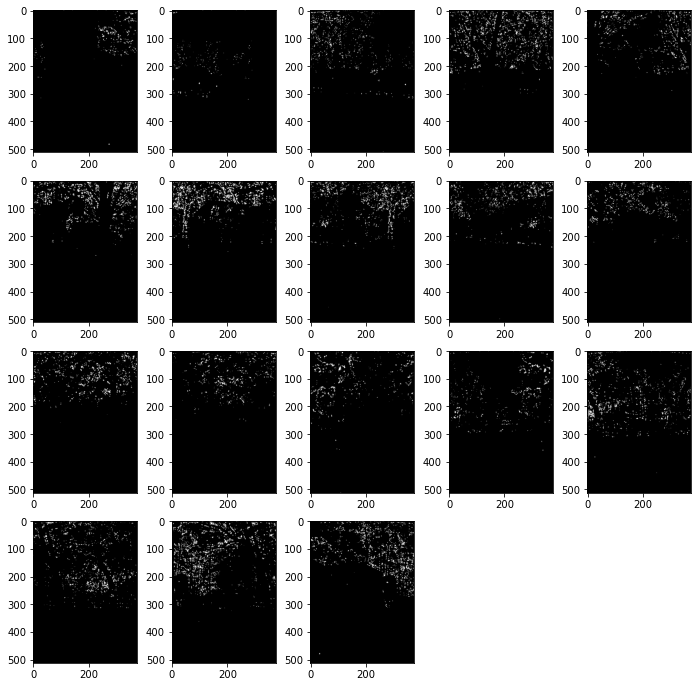

In [68]:
ksize = 3
gksize = 3
k = 0.05
threshold = 1
harris_images = []
plt.figure(figsize=(12,12))
for i, img in enumerate(result_images):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    harris_img = harris(gray_img, ksize, gksize, k, threshold)
    
    dilate_img = cv2.dilate(harris_img, np.ones((3,3)))
    cv2.threshold(harris_img, harris_img.max()*0.01, 255, cv2.THRESH_BINARY, harris_img)
    

    
    harris_images.append(harris_img) 
    plt.subplot(4, math.ceil(len(result_images)/4), i+1)
    plt.imshow(harris_img, cmap="gray")
